In [1]:
%%capture
# Running the previous notebooks
%run TSP.ipynb
%run TSPextended.ipynb
%run LocalSearch.ipynb
%run EvolutionaryAlgorithmTSP.ipynb
%run EvolutionaryAlgorithmFSTSP.ipynb

#Importing their classes
tsp = TSP()
tsp_ext = TSPext()
localsearch = LocalSearch()

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import scipy.stats as stats
import time as time

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import scipy.stats as stats
import time as time
import sklearn

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
from pingouin import ancova

In [5]:
columns = [i for i in range(1,26)]
distance_dataframe = pd.read_csv('distance_dataframes/dist_dataframe_normal_1_25_wo:0.csv',names = columns)
distance_dataframe = distance_dataframe.iloc[1:]
distance_dataframe.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,0.00,0.35,0.59,0.30,0.20,0.22,0.49,0.68,0.59,0.50,...,0.24,0.43,0.44,0.84,0.37,0.54,0.27,0.29,0.33,0.16
2,0.35,0.00,0.29,0.08,0.17,0.35,0.22,0.70,0.54,0.32,...,0.53,0.41,0.55,0.60,0.30,0.20,0.21,0.23,0.27,0.21
3,0.59,0.29,0.00,0.30,0.44,0.48,0.40,0.96,0.79,0.54,...,0.80,0.40,0.83,0.73,0.57,0.29,0.34,0.51,0.55,0.42
4,0.30,0.08,0.30,0.00,0.15,0.27,0.29,0.73,0.59,0.38,...,0.50,0.34,0.56,0.68,0.33,0.28,0.14,0.25,0.30,0.14
5,0.20,0.17,0.44,0.15,0.00,0.29,0.30,0.61,0.49,0.33,...,0.36,0.44,0.42,0.66,0.23,0.35,0.22,0.14,0.19,0.13


Importing the class $eaFSTSP\_One\_OXC\_swap$ from $FSTSP\_EDA$.

In [6]:
#Defining the class
class eaFSTSP_One_OXC_swap:
    def __init__(self, population_size, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        self.fstsp = eaFSTSP(self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.population_size, self.number_of_cities)
        
    #Initialize and evaluate population
    def initialize(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.drone_endurance = drone_endurance
        self.routes, self.allocation, self.population, self.fitness = self.fstsp.random_initialization(drone_endurance, inverse_truck_speed, inverse_drone_speed)
        return(self.routes, self.allocation, self.population, self.fitness)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations):
        #We can record time it takes for the loop 
        init_time = time.time()   
        
        generation_number =0
        initial_population = self.population
        initial_allocation = self.allocation
        self.fitness_array = []
        self.duplicates = []
        while(generation_number<total_generations):
            #Select parents
            mating_pool, allocation_pool = self.fstsp.parent_selection_tournament(number_of_parents, self.routes, self.allocation,self.fitness,tournament_size, tournament_probability)
            #Recombination
            offspring_database, offspring_allocation_database = self.fstsp.order_one_crossover_c(mating_pool, allocation_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df, mutated_allocation_arrays_df = self.fstsp.two_opt_swap(offspring_database, offspring_allocation_database, mutation_probability)
            #Evaluation
            offspring_with_fitness, offspring_allocation = self.fstsp.evaluation(mutated_offspring_df, mutated_allocation_arrays_df)
            offspring_with_fitness.columns = initial_population.columns
            offspring_allocation.columns = initial_allocation.columns
            #Replacement
            next_population, next_allocation = self.fstsp.replacement(self.population, offspring_with_fitness, initial_allocation, offspring_allocation)
            #Preparing for next generation
            self.routes = next_population.drop(next_population.columns[-1], axis=1)
            self.allocation = next_allocation
            self.fitness = next_population.iloc[:, -1].values.tolist()
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)
            
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            generation_number = generation_number + 1
        
        #Recording the end time
        final_time = time.time()
        
        total_time = final_time - init_time
        
        return(next_population, next_allocation, self.fitness, self.fitness_array, total_time, self.duplicates)
        
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.show()

We are going to use this class to run the EA with specific parameter values on the dataframe 30 times. Then we will take the average fitness and the average run time across those 30 values.

In [7]:
def EA_parameter_test(distance_dataframe, drone_scaling_factor, drone_battery_life, population_size,number_of_parents, tournament_size, tournament_probability, mutation_probability, total_generations):  
    array_max_fitness_values = []
    array_run_time_values = []
    array_duplicate_count = []
    
    counter = 0
    
    truck_scaling_factor = 1
    number_of_cities = 25 
    number_of_offspring = population_size
    
    truck_time_dataframe, drone_time_dataframe = multiplydistancedataframe(distance_dataframe,  truck_scaling_factor, drone_scaling_factor)

    while(counter<15):
        #Initialise
        ea = eaFSTSP_One_OXC_swap(population_size=population_size, number_of_cities=number_of_cities, distance_matrix=distance_dataframe, truck_distance_matrix=truck_time_dataframe, drone_distance_matrix=drone_time_dataframe)
        ea.initialize(drone_battery_life, truck_scaling_factor, drone_scaling_factor)
        #Obtain final fitness value from ending population
        run = ea.mainLoop(number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations)
        maximum_finishing_fitness_value = np.amax(run[3])
        #Appending values
        array_run_time_values.append(run[4])
        array_max_fitness_values.append(maximum_finishing_fitness_value)
        array_duplicate_count.append(run[5])
        counter = counter + 1
        
    array_max_fitness_values = np.array(array_max_fitness_values)
    average_fitness = np.mean(array_max_fitness_values)
    
    array_duplicate_count = np.array(array_duplicate_count)
    final_duplicate_number = np.max(array_duplicate_count[-1])
    
    array_run_time_values = np.array(array_run_time_values)
    average_time = np.mean(array_run_time_values)
        
    return(average_fitness, average_time, final_duplicate_number)

In [8]:
#Test
tmp = EA_parameter_test(distance_dataframe, 1, 1, 100, 75, 3, 0.9, 0.1, 100)

In [9]:
tmp

(-5.335333333333335, 35.44714331626892, 29)

In order to obtain a set of experimental parameter values to run the experiment on, we will use a latin hypercube.

In [ ]:
#Latin hypercube for parameter values
ln = qmc.LatinHypercube(8)

In [ ]:
sample = ln.random(n=100)

In [ ]:
#Parameters are drone_scaling_factor, drone_endurance, population_size,number_of_parents, tournament_size, tournament_probability, mutation_probability, total_generations
#Scaling the parameters
l_bounds = [0.1, 0.1, 100, 0.1, 1, 0.1, 0.1, 100]
u_bounds = [1, 1, 500, 1, 5, 1, 1, 500]
parameter_ranges = qmc.scale(sample, l_bounds, u_bounds)

In [ ]:
parameter_ranges

In [ ]:
#Rounding the appropriate parameters (population size, number of parents, tournament size, number of generations) to integer range
for i in range(100):    
    parameter_ranges[i] = np.round(parameter_ranges[i], 2)
    parameter_ranges[i][2] = int(parameter_ranges[i][2])
    parameter_ranges[i][4] = int(parameter_ranges[i][4])
    parameter_ranges[i][7] = int(parameter_ranges[i][7])

In [ ]:
parameter_ranges[1]

In [ ]:
#Running the EA for each parameter combination
fitness = []
times = []
duplicates = []

for i in range(100):
    drone_scaling_factor, drone_endurance, population_size,number_of_parents, tournament_size, tournament_probability, mutation_probability, total_generations =  parameter_ranges[i, [0]][0], parameter_ranges[i, [1]][0], int(parameter_ranges[i, [2]][0]), int(parameter_ranges[i, [3]][0] * int(parameter_ranges[i, [2]][0])), int(parameter_ranges[i, [4]][0]), parameter_ranges[i, [5]][0], parameter_ranges[i, [6]][0], int(parameter_ranges[i, [7]][0])
    tmp = EA_parameter_test(distance_dataframe, drone_scaling_factor, drone_endurance, population_size, number_of_parents, tournament_size, tournament_probability, mutation_probability, total_generations)
    new_fitness = tmp[0]
    new_times = tmp[1]
    new_duplicates = tmp[2]

    fitness.append(new_fitness)
    times.append(new_times)
    duplicates.append(new_duplicates)

In [ ]:
len(fitness)

In [ ]:
fitness_df = pd.DataFrame(fitness)

In [ ]:
fitness_df

In [ ]:
times_df = pd.DataFrame(times)

In [ ]:
duplicates_df = pd.DataFrame(duplicates)

In [ ]:
fitness_df.to_csv('fitness.csv')

In [ ]:
times_df.to_csv('times')

In [ ]:
duplicates_df.to_csv('duplicates.csv')

Creating the results dataframe

In [ ]:
parameters = parameter_ranges[0:37]

In [ ]:
parameters_df = pd.DataFrame(parameters)

In [ ]:
parameters_df = parameters_df.rename(columns={0: 'drone_scaling_factor', 1: 'drone_endurance', 2:'population_size', 3:'proportion_of_parents', 4:'tournament_size', 5:'tournament_probability', 6:'mutation_probability', 7: 'total_generations'})
                       

In [ ]:
parameters_df

In [ ]:
df = pd.concat([parameters_df, fitness_df], axis = 1)

In [ ]:
df = df.rename(columns={0: 'Fitness'})

In [ ]:
df.to_csv('Parameter_Experimentation.csv')

In [ ]:
df

#### Determining optimal values


In [ ]:
df['Fitness'].argmax()

In [ ]:
df.iloc[30]

#### Let us compare the FSTSP model with these parameters against the TSP model with the same parameters

In [12]:
#Initializing eaTSP_ONE from EvolutionaryAlgorithmTSP.ipynb with parameters and running it 25 times
fitness = []

for i in range(25):
    ea = eaTSP_ONE(390, 25, distance_dataframe)
    ea.initialize()
    ea_run = ea.mainLoop(160, 390, 3, 0.83, 0.16, 291)
    new_fitness = ea_run.loc[1]['Fitness']
    fitness.append(new_fitness)

KeyboardInterrupt: 

In [15]:
fitness_df = pd.DataFrame(fitness)

In [17]:
fitness_df.to_csv('TSP_Optimal_Parameters_Results.csv')

In [21]:
#Running eaFSTSP_One_OXC_swap again 25 times with the optimal parameters
def EA_optimal_parameter_test(distance_dataframe, drone_scaling_factor, drone_battery_life, population_size,number_of_parents, tournament_size, tournament_probability, mutation_probability, total_generations):  
    array_max_fitness_values = []
    
    counter = 0
    
    truck_scaling_factor = 1
    number_of_cities = 25 
    number_of_offspring = population_size
    
    truck_time_dataframe, drone_time_dataframe = multiplydistancedataframe(distance_dataframe,  truck_scaling_factor, drone_scaling_factor)

    while(counter<25):
        #Initialise
        ea = eaFSTSP_One_OXC_swap(population_size=population_size, number_of_cities=number_of_cities, distance_matrix=distance_dataframe, truck_distance_matrix=truck_time_dataframe, drone_distance_matrix=drone_time_dataframe)
        ea.initialize(drone_battery_life, truck_scaling_factor, drone_scaling_factor)
        #Obtain final fitness value from ending population
        run = ea.mainLoop(number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations)
        maximum_finishing_fitness_value = np.amax(run[3])
        #Appending values
        array_max_fitness_values.append(maximum_finishing_fitness_value)
        counter = counter + 1
        print(f"Completed run {counter}")
        
    return(array_max_fitness_values)

In [22]:
fitness = EA_optimal_parameter_test(distance_dataframe, 0.15, 0.32, 390, int(390*0.41), 3, 0.83, 0.16, 291)

Completed run 1
Completed run 2
Completed run 3
Completed run 4
Completed run 5
Completed run 6
Completed run 7
Completed run 8
Completed run 9
Completed run 10
Completed run 11
Completed run 12
Completed run 13
Completed run 14
Completed run 15
Completed run 16
Completed run 17
Completed run 18
Completed run 19
Completed run 20
Completed run 21
Completed run 22
Completed run 23
Completed run 24
Completed run 25


In [23]:
fitness

[-3.8000000000000007,
 -3.7200000000000006,
 -3.6600000000000006,
 -3.740000000000001,
 -3.6200000000000006,
 -3.5300000000000002,
 -3.630000000000001,
 -3.6800000000000006,
 -3.6400000000000006,
 -3.79,
 -3.6400000000000006,
 -3.7300000000000004,
 -3.8400000000000007,
 -3.73,
 -3.460000000000001,
 -3.6700000000000004,
 -3.71,
 -3.6000000000000005,
 -3.6,
 -3.650000000000001,
 -3.5700000000000007,
 -3.6,
 -3.670000000000001,
 -3.6400000000000006,
 -3.680000000000001]

In [24]:
fitness_df = pd.DataFrame(fitness)

In [25]:
fitness_df.to_csv('FSTSP_Optimal_Parameters_Results.csv')

#### Creating the histogram

In [29]:
df1 = pd.read_csv('TSP_Optimal_Parameters_Results.csv', index_col=  'Unnamed: 0')
df2 = pd.read_csv('FSTSP_Optimal_Parameters_Results.csv', index_col=   'Unnamed: 0')

In [34]:
data1 = df1['0']

In [36]:
data2 = df2['0']

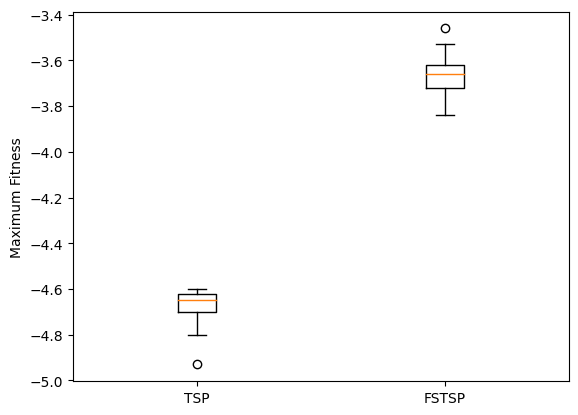

In [42]:
#Plotting the box-plot
fig, ax = plt.subplots()
ax.boxplot([data1, data2])

ax.set_xticklabels(['TSP', 'FSTSP'])
ax.set_ylabel('Maximum Fitness')

plt.savefig('boxplot3.jpg', format='jpg')

In [49]:
#Average effeciency gain
np.mean(data1)/np.mean(data2) -1

0.2769650655021827